In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import seaborn as sns
import threading

sns.set_style("darkgrid",{'xtick.top': True, 'ytick.right': True,'xtick.bottom': True, 'ytick.left': True,'grid.linestyle': '--','image.cmap': 'viridis','xtick.direction': 'in',
 'ytick.direction': 'in'})

# @working path
FIG_PATH     = '../tex/figs/'
WEB_FIG_PATH = '../tex/web-figs/'
DATA_PATH    = '../code/'


# @global settings
WEB_FIG_DPI  = 600
FIG_DPI      = 800
FIG_EXT      = '.pdf'
WEB_FIG_EXT  = '.png'

# @global functions
def savefig(handler,name, fig_ext = FIG_EXT, web_fig_ext = WEB_FIG_EXT):
    if name != '':
        handler.savefig(FIG_PATH + name + fig_ext, dpi = FIG_DPI,bbox_inches = 'tight', pad_inches = 0.1)
    #handler.savefig(WEB_FIG_PATH + name + web_fig_ext, dpi = WEB_FIG_DPI,bbox_inches = 'tight', pad_inches = 0.1)

Populating the interactive namespace from numpy and matplotlib


In [ ]:

PC     = 648000/np.pi
KPC    = 1000*PC 
AU     = 1
MS     = 1
YR     = 2 * np.pi
Hubble_t = 13.4e9*YR
V_UNIT = 2.9784651272402163E1
KMS    = 1.0/V_UNIT
lc     = 299792.458/V_UNIT
DAY    = YR/365.25636042
HR     = DAY/24
G= 1

In [ ]:
def load_orbit(data,orbit_name):
    name = ['m1', 'm2', 'p', 'e', 'i', 'Omega', 'omega', 'nv']
    orbit={}
    for key, i in zip(name, range(len(name))):
        orbit.update({orbit_name+key : data[:,i]})
    return orbit

def load_incid_args(data):
    return {'v_inf': data[:,0], 'b':data[:,1], 'w':data[:,2], 'ii':data[:,3],'iphi':data[:,4]}

def load_post_scattered(data, obj_name):
    dic = {'time':data[:,0]}
    for name, idx in zip(obj_name, range(len(obj_name))):
        offset = 10*idx
        print(offset, name)
        dic.update({'m_{' + name + '}': data[:,offset + 3],
                    'r_{' + name + '}': data[:,offset + 4],
                    'px_{' + name + '}': data[:,offset + 5],
                    'py_{' + name + '}': data[:,offset + 7],
                    'pz_{' + name + '}': data[:,offset + 7],
                    'vx_{' + name + '}': data[:,offset + 8],
                    'vy_{' + name + '}': data[:,offset + 9],
                    'vz_{' + name + '}': data[:,offset + 10]
                   })
    return dic
        
def load_closest(data, obj_name):
    dic ={}
    for name, idx in zip(obj_name, range(len(obj_name))):
        offset = 6*idx
        dic.update({'closest:px_{' + name + '}': data[:,offset + 0],
                    'closest:py_{' + name + '}': data[:,offset + 1],
                    'closest:pz_{' + name + '}': data[:,offset + 2],
                    'closest:vx_{' + name + '}': data[:,offset + 3],
                    'closest:vy_{' + name + '}': data[:,offset + 4],
                    'closest:vz_{' + name + '}': data[:,offset + 5]})
    return dic
        
def load_data(fname, os, objname):
    data = np.loadtxt(fname)
    
    dic = {}
    dic.update(load_orbit(data[:,os['incident-orbit-s']:os['incident-orbit-e']],'incident-orbit-') )
    #dic.update(load_incid_args(data[:,os['incident-s']:os['incident-e']]))
    
    dic.update(load_post_scattered(data[:,os['post-s']:os['post-e']], objname))
    
    if 'closest-s' and 'closest-e' in os:
        dic.update(load_closest(data[:,os['closest-s']:os['closest-e']], objname))
    
    if 'sn-orbit-s' and 'sn-orbit-e' in os:
        dic.update(load_orbit(data[:,os['sn-orbit-s']:os['sn-orbit-e']],'sn-orbit-'))
        
    if 'ss-orbit-s' and 'ss-orbit-e' in os:
        dic.update(load_orbit(data[:,os['ss-orbit-s']:os['ss-orbit-e']],'ss-orbit-'))
        
    return dic


def get_a_e(m, drx, dry, drz, dvx, dvy, dvz):
    r  = np.sqrt(drx**2 + dry**2 + drz**2)
    v2 = dvx**2 + dvy**2 + dvz**2
    v  = np.sqrt(v2)
    
    vrdot = drx*dvx + dry*dvy + drz*dvz
    
    vdfsq = (v2 - m / r)
    ex = (vdfsq * drx - vrdot * dvx)
    ey = (vdfsq * dry - vrdot * dvy) 
    ez = (vdfsq * drz - vrdot * dvz) 
    e  = np.sqrt(ex * ex + ey * ey + ez * ez) / m
    a  = -m / (v2 - 2 * m/r)
    return a, e


def calc_pair_a_e(data, pairs):
    dic = {}
    for name_i, name_j in pairs:
        mi = data['m_{' + name_i + '}']
        mj = data['m_{' + name_j + '}']
        
        dpx = data['px_{' + name_i + '}'] - data['px_{' + name_j + '}']
        dpy = data['py_{' + name_i + '}'] - data['py_{' + name_j + '}']
        dpz = data['pz_{' + name_i + '}'] - data['pz_{' + name_j + '}']
        
        dvx = data['vx_{' + name_i + '}'] - data['vx_{' + name_j + '}']
        dvy = data['vy_{' + name_i + '}'] - data['vy_{' + name_j + '}']
        dvz = data['vz_{' + name_i + '}'] - data['vz_{' + name_j + '}']
        

        a, e = get_a_e(mi + mj, dpx, dpy, dpz, dvx, dvy, dvz)
        dic.update({'a_{' + name_i + ',' + name_j + '}': a,  'e_{' + name_i + ',' + name_j + '}': e})
    return dic
        
def calc_tidal_t_scale(data, star_name, planet_name='j'):
    mp = data['m_{'+planet_name+ '}']
    rp = data['r_{'+planet_name+ '}']
    dic = {}
    for name in star_name:
        rs = data['r_{' + name + '}']
        ms = data['m_{' + name + '}']
        #s = 9.0/4/2e7*mp/ms*rs**5
        p = 9.0/4/2.5e4*ms/mp*rp**5
        a = data['a_{' + name + ',' + planet_name + '}']
        e = data['e_{' + name + ',' + planet_name + '}']
        n = np.sqrt( G*(ms+mp)/a**3)
        tau_ap = 3/n*a**5/14/e**2/p
        dic.update({'T_{' + name + ',' + planet_name + '}' : tau_ap})
    return dic

def check_collision(data, pairs):
    dic ={}
    for name_i, name_j in pairs:
        ri = data['r_{' + name_i + '}']
        rj = data['r_{' + name_j + '}']
        
        dpx = data['px_{' + name_i + '}'] - data['px_{' + name_j + '}']
        dpy = data['py_{' + name_i + '}'] - data['py_{' + name_j + '}']
        dpz = data['pz_{' + name_i + '}'] - data['pz_{' + name_j + '}']
        
        
        coll = (dpx**2 + dpy**2 + dpz**2) <= (ri + rj)**2
        
        
        data['star outcome'][coll] = 'coll_{' + name_i + ',' + name_j + '}'
        data['planet outcome'][coll] = 'coll_{' + name_i + ',' + name_j + '}'
        #dic.update({'coll_{' + name_i + ',' + name_j + '}': coll})
    #return dic

def classify_star_outcome(data, star_pairs):
    init_bound = np.ones(data['time'].shape, dtype=bool)
    init_unbound =np.ones(data['time'].shape, dtype=bool)
    disrupted = np.zeros(data['time'].shape, dtype=bool)
    
    for name_i, name_j in star_pairs:
        if (name_i == 's1') and (name_j == 's2'):
            a = data['a_{' + name_i + ',' + name_j + '}']
            e = data['e_{' + name_i + ',' + name_j + '}']
        
            bound = (a > 0) & (0 <=e) & (e < 1)
            unbound = (e >= 1) & (a <= 0) 
            init_bound = init_bound & bound
            init_unbound=init_unbound&unbound
            disrupted = np.ones(data['time'].shape, dtype=bool)
    
    
    flyby = np.ones(data['time'].shape, dtype=bool)
    
    bi_formation ={}
    for name_i, name_j in star_pairs:
        if (name_i != 's1') or (name_j != 's2'):
            a = data['a_{' + name_i + ',' + name_j + '}']
            e = data['e_{' + name_i + ',' + name_j + '}']
        
            bound = (a > 0) & (0 <=e) & (e < 1)
            unbound = (e >= 1) & (a <= 0) 
            
            bi_formation.update({'reunion_{' + name_i + ',' + name_j + '}': bound & init_unbound})
        
            flyby = flyby & unbound & init_bound
            
            disrupted = disrupted & unbound & init_unbound
        
    reunion = np.zeros(data['time'].shape, dtype=bool)
    for key, r in bi_formation.items():
        reunion = reunion | r
        
    data['star outcome'][reunion] = 'reunion'
    data['star outcome'][flyby]  = 'flyby'
    data['star outcome'][disrupted] = 'disrupted'
    
    #dic = {'reunion':reunion, 'flyby' : flyby, 'disrupted': disrupted}
    
    #dic.update(bi_formation)
            
    #return dic

def classify_planet_outcome(data, star_names, planet_name='j', a_final=0.1*AU):
    binary = []
    for star_name in star_names:
        a = data['a_{' + star_name + ',' + planet_name + '}']
        e = data['e_{' + star_name + ',' + planet_name + '}']
        tau_ap = data['T_{' + star_name + ',' + planet_name + '}']
        
        bound = (a > 0) & (0 <=e) & (e < 1)
        unbound = (e >= 1) & (a <= 0) 
        hot_jupiter_candi = (a*(1-e*e) < a_final) & (tau_ap < Hubble_t) 
        binary.append((star_name, bound, unbound, hot_jupiter_candi))
        
    dic={}
    for star_name1, bound1, unbound1, hj1 in binary:
        bound = bound1
        hot_jupiter = hj1
        for star_name2, bound2, unbound2, hj2 in binary:
            if(star_name1 != star_name2):
                bound = bound & unbound2
                hot_jupiter = hot_jupiter & unbound2
                
        data['planet outcome'][bound] = 'stay_{' + star_name1 + ',' + planet_name + '}'
        data['planet outcome'][hot_jupiter] = 'HJ_{' + star_name1 + ',' + planet_name + '}' 
    
        #dic.update({'stay_{' + star_name1 + ',' + planet_name + '}' : bound, 'HJ_{' + star_name1 + ',' + planet_name + '}' : hot_jupiter})
        
    ejection = np.ones(data['time'].shape, dtype=bool)
    for star_name, bound, unbound, hj in binary:
        ejection = ejection & unbound
        
    data['planet outcome'][ejection] = 'ejection_{'+planet_name+'}'
    
    
def post_process(fname, os, objname, pairs):
    star_name = [ name for name in objname if name.startswith('s')]
    planet_name = [ name for name in objname if not name.startswith('s')]
    star_pairs = [(s1, s2) for s1, s2 in pairs if s1.startswith('s') and s2.startswith('s')]
    
    print(star_name, planet_name, star_pairs)
    
    data = load_data(fname, os, objname)
    
    data.update({'star outcome':np.zeros(data['time'].shape,dtype = object)})
    data.update({'planet outcome':np.zeros(data['time'].shape,dtype = object)})
    data.update(calc_pair_a_e(data, pairs))
    
    classify_star_outcome(data, star_pairs)
   
    
    for p_name in planet_name:
        data.update(calc_tidal_t_scale(data, star_name, p_name))
        classify_planet_outcome(data, star_name, p_name)
        
    check_collision(data, pairs)
    
    return data

def get_ss_final_data(v_inf, aj, df):
    p = df['incident-orbit-p']
    e = df['incident-orbit-e']
    b = p / np.sqrt(e**2 - 1)
    b_max = b[np.isfinite(b)].max()
    
    pfate = df['planet outcome']
    sfate = df['star outcome']
    
    ej = pfate == 'ejection_{j}'
    
    coll_ss = (sfate== 'coll_{s,s1}' )
    coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}')
    
    stay = pfate == 'stay_{s,j}'
    capture = pfate == 'stay_{s1,j}'
    
    ntot = len(pfate)
    
    return v_inf, aj, b_max, ej.sum()/ntot, coll_ss.sum()/ntot, coll_sj.sum()/ntot, stay.sum()/ntot, capture.sum()/ntot
    

In [ ]:
import csv
def write_list_to_file(data, filename):
    """Write the list to csv file."""
    with open(filename,'w') as out:
        csv_out=csv.writer(out)
        #csv_out.writerow(['name','num'])
        for row in data:
            csv_out.writerow(row)
    
        #v.write("\n")



In [ ]:
v=np.array([0.1, 3.42222222,  6.74444444,  10.06666667, 13.38888889, 16.71111111, 20.03333333, 23.35555556, 26.67777778, 30])

v_name =['0.1', '3.4', '6.7', '10.1', '13.4', '16.7', '20.0', '23.4', '26.7', '30.0']
a_j = ['0.1', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0']

In [ ]:
def deal(lists, fname, os, objname, pairs, vv, aj):
    lists.append(get_ss_final_data(float(vv), float(aj), pd.DataFrame(post_process(fname, os, objname, pairs))))
    
lists = []
threads =[]

for vv in v_name:
    for aj in a_j:
        threads.append( threading.Thread(target=deal, args=(lists, prefix+vv+'_'+aj+'.txt', mono_single_idx, names, pairs, vv, aj)) )
        
for th in threads:
    th.start()
    
for th in threads:
    th.join()

In [ ]:
prefix = '../code/ss/solar-normal-ss_ss_'

mono_single_idx = {'incident-orbit-s' : 40, 'incident-orbit-e':48, 'post-s':1, 'post-e':32}

names = ['s','j', 's1']

pairs = [('s','j'), ('s','s1'), ('s1','j')]
    
stat = []
for vv in v_name:
    for aj in a_j:
        s = get_ss_final_data(pd.DataFrame(post_process(prefix+vv+'_'+aj+'.txt', mono_single_idx, names, pairs)))
        stat.append([vv, aj, s])

In [ ]:
new_list =[]
for x in stat:
    new_list.append((float(x[0]),float(x[1]),x[2][0],x[2][1], x[2][2], x[2][3], x[2][4], x[2][5] ))
print(new_list)

In [ ]:
write_list_to_file(new_list, 'single-single.csv')

In [ ]:
def a_h(sigma, M):
    return G*M/sigma**2

a_h_02 = a_h(v_inf, 0.2)

a_p_max_02 = a_h_02 / stab_ratio

a_h_1 = a_h(v_inf, 1)

a_p_max_1 = a_h_1 / stab_ratio


plt.plot(v_inf/KMS, a_p_max_02/AU)
plt.axhline(5)
plt.axhline(0.1)
plt.xscale('log')
plt.yscale('log')

In [14]:
df=pd.DataFrame(pd.read_csv('single-single_bk.csv',skipinitialspace=True))
df

,vel,aj,b_max,ejection,s_coll,p_coll,stay,cap
0,0.1,0.1,0.000000,0.150572,0.020245,0.020790,0.448950,0.039528
1,0.1,0.5,823.512708,0.156506,0.003953,0.004775,0.722049,0.072448
2,0.1,1.0,1190.783720,0.157552,0.002053,0.002562,0.747298,0.075836
3,0.1,1.5,1426.370339,0.157230,0.001316,0.001757,0.754381,0.076858
4,0.1,2.0,1647.037661,0.157483,0.000985,0.001381,0.756387,0.077805
...,...,...,...,...,...,...,...,...
105,30.0,3.0,12.870686,0.077398,0.000176,0.000186,0.910642,0.009693
106,30.0,3.5,14.730921,0.073605,0.000124,0.000141,0.918091,0.006597
107,30.0,4.0,16.586930,0.069351,0.000102,0.000103,0.924088,0.005262
108,30.0,4.5,18.440073,0.065050,0.000080,0.000109,0.929658,0.004136


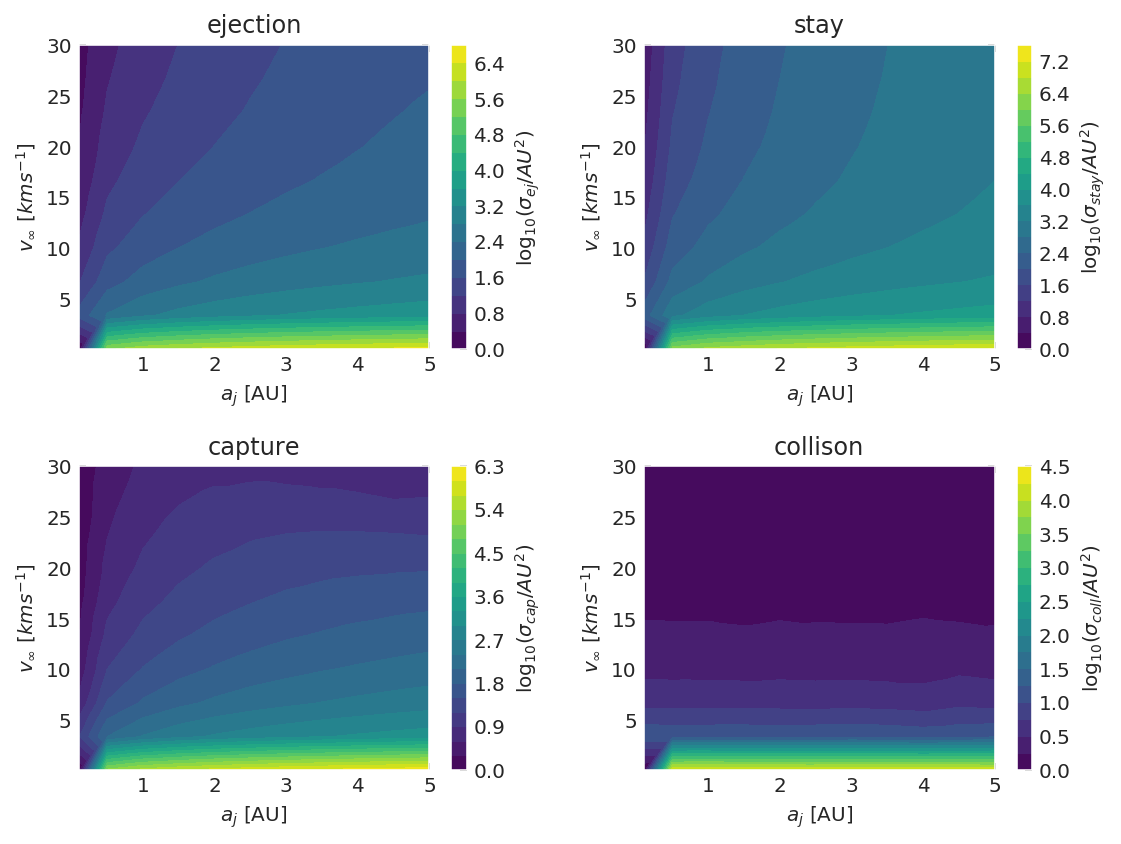

In [43]:

def show_cross(df):
    x=np.array(df['aj'])
    y=np.array(df['vel'])
    xlabel='$a_j$ [AU]'
    ylabel='$v_\infty$ [$kms^{-1}$]'
    fig=plt.figure(figsize=(8,6))
    delta = 1
    ax=fig.add_subplot(2,2,1)
    cs= np.log10(np.array(df['b_max'])**2*np.pi*np.array(df['ejection']) + delta)
    im=ax.tricontourf(x,y, cs,20)
    cb=plt.colorbar(im)
    cb.set_label('$\log_{10}(\sigma_{ej}/AU^2)$') 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('ejection')
    
    ax=fig.add_subplot(2,2,2)
    cs=np.log10(np.array(df['b_max'])**2*np.pi*np.array(df['stay']) + delta)
    im=ax.tricontourf(x,y, cs,20)
    cb=plt.colorbar(im)
    cb.set_label('$\log_{10}(\sigma_{stay}/AU^2)$') 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('stay')
    
    ax=fig.add_subplot(2,2,3)
    cs=np.log10(np.array(df['b_max'])**2*np.pi*np.array(df['cap'])+delta)
    im=ax.tricontourf(x,y,cs,20)
    cb=plt.colorbar(im)
    cb.set_label('$\log_{10}(\sigma_{cap}/AU^2)$') 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('capture')
    
    ax=fig.add_subplot(2,2,4)
    cs=np.log10(np.array(df['b_max'])**2*np.pi*( np.array(df['s_coll']) +  np.array(df['s_coll']) )  + delta)
    im=ax.tricontourf(x,y,  cs,20)
    cb=plt.colorbar(im)
    cb.set_label('$\log_{10}(\sigma_{coll}/AU^2)$') 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('collison')
    
    plt.tight_layout()
    savefig(plt,'solar-normal-ss')
show_cross(df)

In [58]:

print(df['vel'])

0       0.1
1       0.1
2       0.1
3       0.1
4       0.1
       ... 
105    30.0
106    30.0
107    30.0
108    30.0
109    30.0
Name: vel, Length: 110, dtype: float64


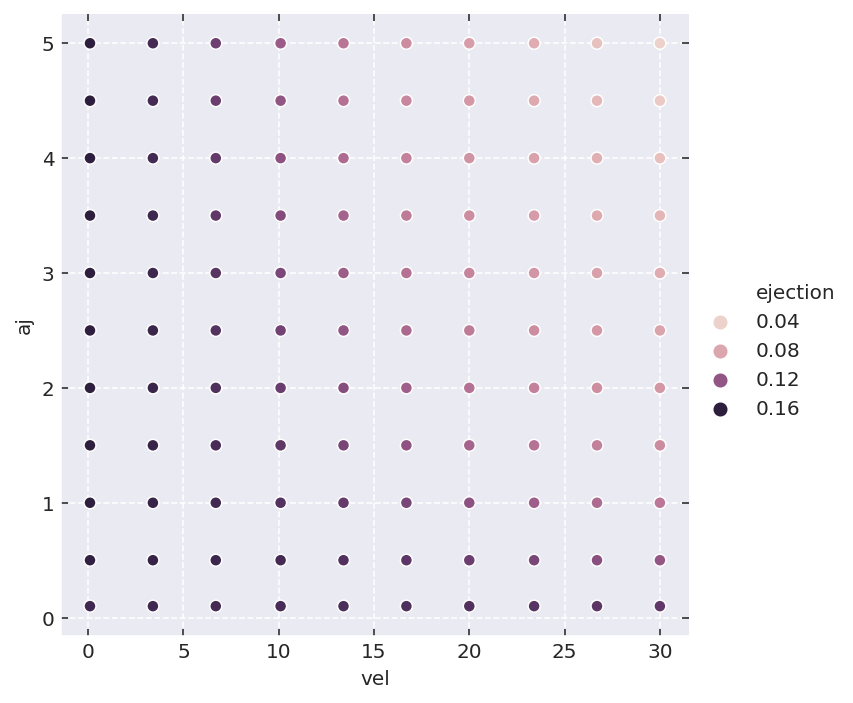

In [61]:
sns.relplot(x='vel',y='aj',hue='ejection',data=df)